In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import cv2

import random

In [2]:
DEFAULT_RANDOM_SEED = 2021

seed = DEFAULT_RANDOM_SEED

random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
'''DATA LOADER'''
class SWEDDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, target_transform=None, index=True):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.index = index

        self.data_dir = os.path.join(root_dir, mode)
        self.image_dir = os.path.join(self.data_dir, 'images')
        self.label_dir = os.path.join(self.data_dir, 'labels')
        
        image_files = sorted([f for f in os.listdir(self.image_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        label_files = sorted([f for f in os.listdir(self.label_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        
        self.pairs = []
        label_suffix = '_chip_' if mode in ['train', 'val'] else '_label_'
        image_dict = {f.replace('_image_', label_suffix): f for f in image_files}
        
        for label_file in label_files:
            if label_file in image_dict:
                self.pairs.append((image_dict[label_file], label_file))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, label_file = self.pairs[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)
        
        if self.mode in ['train', 'val']:
            image = np.load(img_path)
            label = np.load(label_path)
        else:
            image = tifffile.imread(img_path)
            label = tifffile.imread(label_path)
            
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        
        if self.mode in ['train', 'val']:
            image = image.permute(2, 0, 1)
        elif self.mode == 'test':
            image = image.permute(0, 2, 1)
            label = label.unsqueeze(0)
            label = torch.rot90(label, 1, [1, 2])
            label = torch.flip(label, [1])

        image = image / 2.0**15     # jp2 images are 8 to 16 bit
        label = label > 0.0         # binary label

        # bands: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12
        if self.index:
            ndwi1 = (image[2] - image[7]) / (image[2] + image[7] + 1e-6)
            
            # downsample
            lowres = image[2].T.cpu().numpy()
            original_shape = lowres.shape
            lowres = cv2.resize(
                lowres, 
                (lowres.shape[1] // 2, lowres.shape[0] // 2), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = cv2.resize(
                lowres, 
                (original_shape[1], original_shape[0]), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = torch.from_numpy(lowres.T).float()

            ndwi2 = (lowres - image[10]) / (lowres + image[10] + 1e-6)

            image = torch.cat([image, ndwi1.unsqueeze(0), ndwi2.unsqueeze(0)], dim=0)
            
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [4]:
'''GET DATA LOADER'''
def get_dataloaders(root_dir, batch_size=32, num_workers=4, train_transform=None, test_transform=None, device='cuda'):
    train_dataset = SWEDDataset(root_dir, mode='train', transform=train_transform)
    test_dataset = SWEDDataset(root_dir, mode='test', transform=test_transform)

    # train_dataset, val_dataset, _ = random_split(train_dataset, [int(0.01 * len(train_dataset)), 
    #                                                              int(0.01 * len(train_dataset)), 
    #                                                              len(train_dataset) - int(0.02 * len(train_dataset))])

    train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)),  
                                                                 len(train_dataset) - int(0.8 * len(train_dataset))])

    print(f'Train size: {len(train_dataset)}')
    print(f'Validation size: {len(val_dataset)}')
    print(f'Test size: {len(test_dataset)}')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [5]:
'''DISPLAY SAMPLES'''
def display_samples(dataloader, num_samples=5, index=True):
    # Get a batch
    images, masks = next(iter(dataloader))

    # Move to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()

    # Only display up to the requested number of samples
    num_samples = min(num_samples, len(images))
    
    rows = 4 if index else 2
    fig, axes = plt.subplots(rows, num_samples, figsize=(5*num_samples, 5*rows))
    
    idx = 0
    while(idx < num_samples):
        i = np.random.randint(0, len(images))
        if masks[i].sum() == 0:
            continue

        # Display RGB channels (assuming bands 3,2,1 are RGB)
        rgb_img = images[i][[3,2,1]].permute(1,2,0)
        # Normalize for visualization
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        
        axes[0, idx].imshow(rgb_img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Image {idx+1}')
        
        axes[1, idx].imshow(masks[i][0], cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Mask {idx+1}')

        if index:
            axes[2, idx].imshow(images[i][12], cmap='gray')
            axes[2, idx].axis('off')
            axes[2, idx].set_title(f'NDWI1 {idx+1}')

            axes[3, idx].imshow(images[i][13], cmap='gray')
            axes[3, idx].axis('off')
            axes[3, idx].set_title(f'NDWI2 {idx+1}')

        idx += 1
    
    plt.tight_layout()
    plt.show()

Using device: cuda
Train size: 22579
Validation size: 5645
Test size: 98


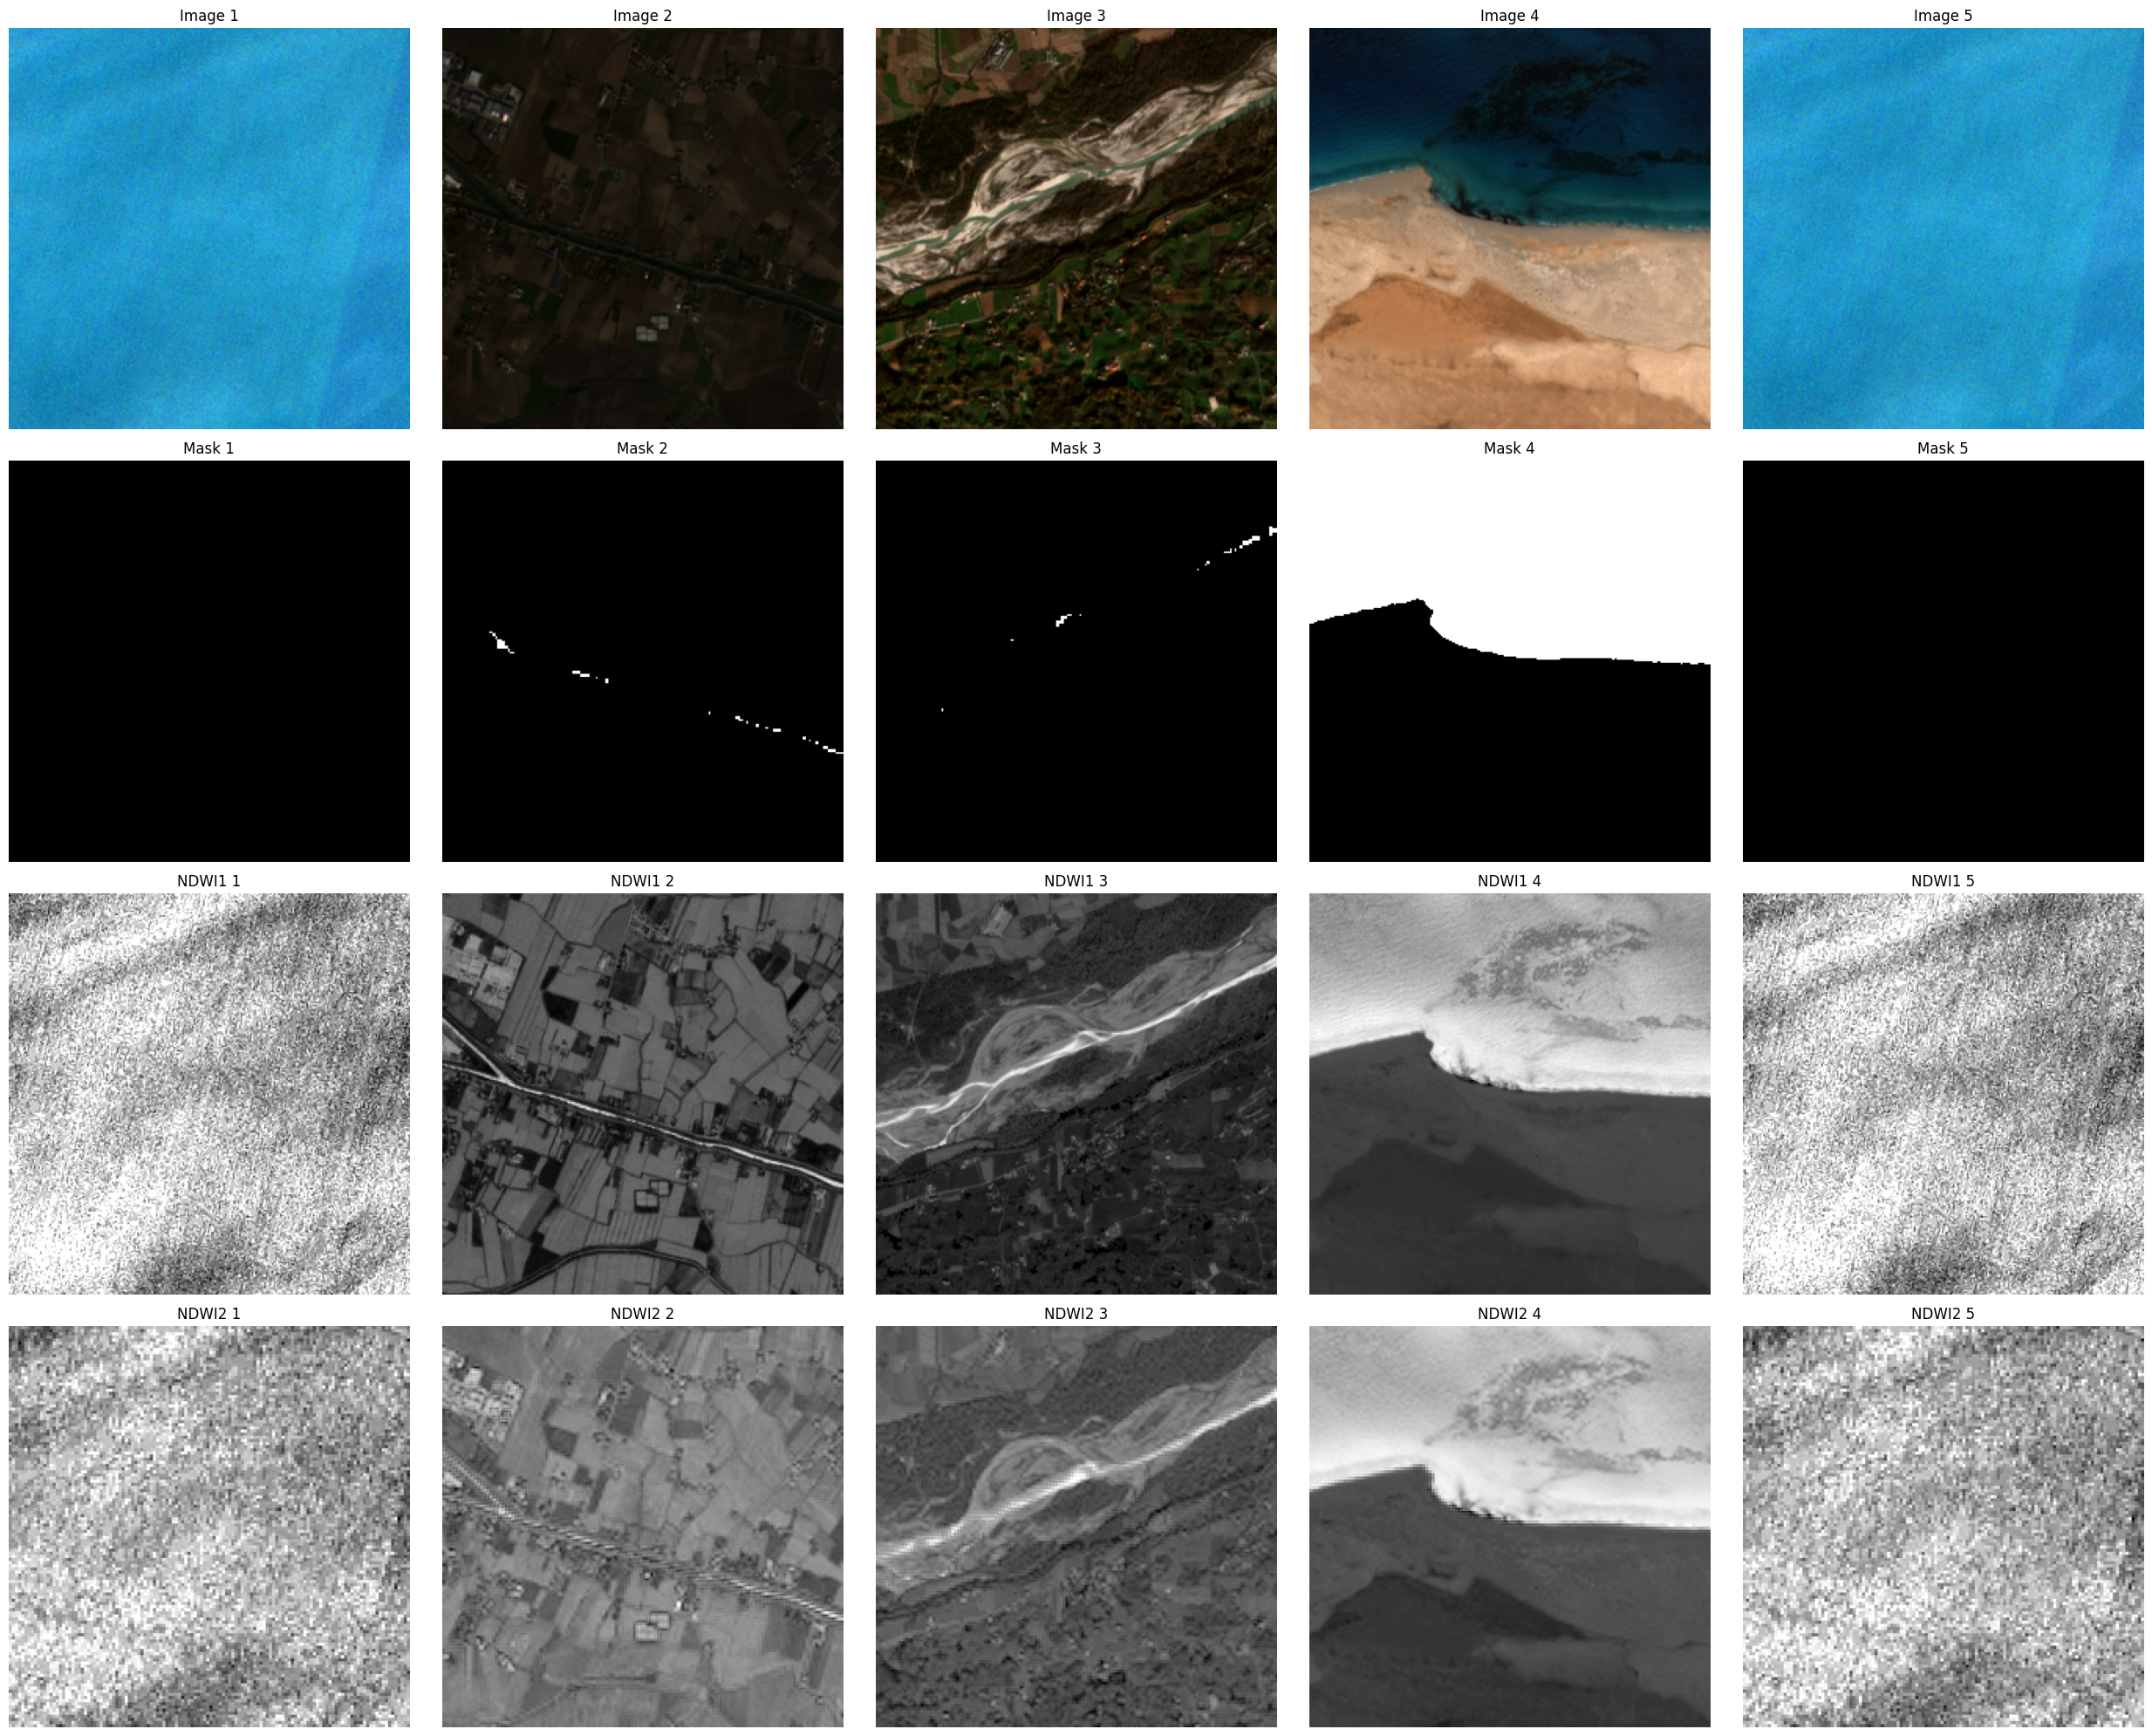

'\n# in case we need standardization\n\nchannel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,\n        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])\nchannel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,\n        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])\n'

In [6]:
'''VISUALIZE SAMPLES'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

root_dir = "/kaggle/input/sentinel-2-water-edges-dataset/SWED"
train_loader, val_loader, test_loader = get_dataloaders(root_dir, batch_size=16, num_workers=4)

# Display 5 samples from training set
display_samples(train_loader, num_samples=5)
# display_samples(test_loader, num_samples=5)

'''
# in case we need standardization

channel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,
        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])
channel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,
        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])
'''

In [7]:
!pip install -q --upgrade torchmetrics

In [8]:
'''TRAINER CLASS'''
from tqdm import tqdm
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex, 
    BinaryCohenKappa, BinaryMatthewsCorrCoef, Accuracy
)
import pandas as pd

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader, device, 
                 scheduler=None, early_stopping_patience=8, min_delta=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.scheduler = scheduler
        self.predictions = None

        # Early stopping parameters
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

    def save_checkpoint(self, epoch, train_loss, val_loss, best_model=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        if best_model:
            save_path = 'best_model.pt'
        else:
            save_path = 'checkpoint.pt'
        torch.save(checkpoint, save_path)
    
    def load_checkpoint(self, checkpoint_path="best_model.pt"):
        if not os.path.exists(checkpoint_path):
            return 0  # Start from scratch if no checkpoint exists
            
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.scheduler and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore loss history
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        
        return checkpoint['epoch']

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for images, labels in tqdm(self.train_loader, desc="train"):
            images, labels = images.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.train_loader.dataset)

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="validation"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.val_loader.dataset)
    
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def train(self, num_epochs, do_plot=True, plot_interval=2, resume=True):
        # Initialize or restore from checkpoint
        self.train_losses = []
        self.val_losses = []
        start_epoch = self.load_checkpoint('checkpoint.pt') if resume else 0
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

        if start_epoch > 0:
            print("Training resumed from epoch ", start_epoch)
    
        for epoch in range(start_epoch, num_epochs):
            if self.early_stopped:
                print("Early stopping triggered.")
                break

            train_loss = self.train_epoch()
            val_loss = self.val_epoch()
    
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            if self.scheduler:
                self.scheduler.step(val_loss)
    
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            self.save_checkpoint(epoch + 1, train_loss, val_loss)
    
            # Early stopping logic
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.early_stopping_counter = 0
                # Save the best model
                self.save_checkpoint(epoch + 1, train_loss, val_loss, best_model=True)
                print(f"New best model saved at epoch {epoch + 1}")
            else:
                self.early_stopping_counter += 1
                print(f"No improvement. Early stopping counter: {self.early_stopping_counter}")
                
                if self.early_stopping_counter >= self.early_stopping_patience:
                    self.early_stopped = True
                    print("Early stopping triggered.")
    
            if do_plot and (epoch % plot_interval == 0 or epoch == num_epochs - 1):
                self.plot_losses(self.train_losses, self.val_losses)
        
        # Load the best model at the end of training
        if os.path.exists('best_model.pt'):
            self.load_checkpoint('best_model.pt')
        
        return self.early_stopped


    def test(self, thres=0.5):
        self.load_checkpoint('best_model.pt')
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() > thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
                all_predictions.extend(outputs.squeeze().cpu().numpy())

        metrics = self.evaluate_torchmetrics(y_pred, y_true)
        metrics.loc[len(metrics)] = ['loss', running_loss / len(self.test_loader.dataset)]  

        return metrics

    def evaluate_torchmetrics(self, y_pred, y_true):
        metrics = {
            "accuracy": BinaryAccuracy(),
            "bal_accuracy": Accuracy(num_classes=2, task="multiclass", average="macro"),
            "precision": BinaryPrecision(),
            "recall": BinaryRecall(),
            "f1_score": BinaryF1Score(),
            "jaccard_index": BinaryJaccardIndex(),
            "cohen_kappa": BinaryCohenKappa(),
            "mcc": BinaryMatthewsCorrCoef()
        }
    
        y_pred = torch.tensor(y_pred).float()
        y_true = torch.tensor(y_true).float()
    
        # result dataframe
        results = pd.DataFrame(columns=["Metric", "Value"])
        for metric_name, metric in metrics.items():
            metric_value = metric(y_pred, y_true)
            results.loc[len(results)] = [metric_name, metric_value.item()]  
            
        return results

    def test_visualize(self, n_samples=5): 
        self.model.eval()
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() > 0.5).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
        for _ in range(n_samples):
            idx = random.randint(0, len(y_true))
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(y_true[idx].reshape(256, 256), cmap='gray')
            axes[0].set_title('True')
            axes[1].imshow(y_pred[idx].reshape(256, 256), cmap='gray')
            axes[1].set_title('Predicted')
            plt.show()


In [9]:
channels = 14

In [10]:
# '''DEEPLAB V3'''
# from torchvision import models

# class DeepLabV3(nn.Module):
#     def __init__(self, num_classes=1):
#         super(DeepLabV3, self).__init__()
#         # Load pretrained DeepLabV3 model with ResNet50 backbone
#         self.model = models.segmentation.deeplabv3_resnet50(pretrained=False)
        
#         # Modify the first layer to accept 12 channels instead of 3
#         self.model.backbone.conv1 = nn.Conv2d(
#             in_channels=12,  # Change input channels to 12
#             out_channels=self.model.backbone.conv1.out_channels,
#             kernel_size=self.model.backbone.conv1.kernel_size,
#             stride=self.model.backbone.conv1.stride,
#             padding=self.model.backbone.conv1.padding,
#             bias=self.model.backbone.conv1.bias is not None
#         )
        
#         # Modify the classifier to output the desired number of classes
#         self.model.classifier[4] = nn.Conv2d(
#             in_channels=256,
#             out_channels=num_classes,
#             kernel_size=(1, 1),
#             stride=(1, 1)
#         )
    
#     def forward(self, x):
#         return self.model(x)['out']

# model = DeepLabV3(num_classes=1).to(device)

In [11]:
model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 
    'unet',
    in_channels=channels,  # Set input channels to 12
    out_channels=1,  # Output channel remains 1 for the mask
    init_features=32, 
    pretrained=False  # Pretraining is not available for 12 channels
)

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.65, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        pred, target = pred.squeeze(), target.squeeze()
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()


pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
focal_loss(pred, target)

tensor(2829.4861)

validation: 100%|██████████| 353/353 [00:53<00:00,  6.54it/s]


Epoch 1/40
Training Loss: 4601.3288
Validation Loss: 3945.3856
New best model saved at epoch 1


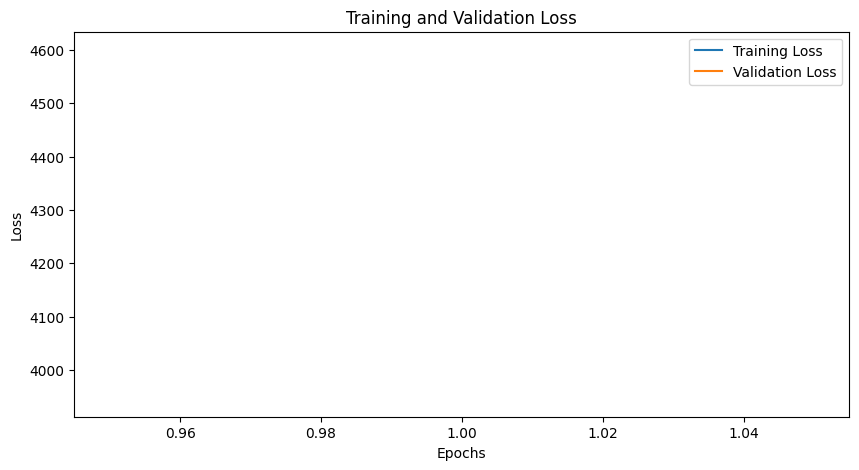

validation: 100%|██████████| 353/353 [00:36<00:00,  9.63it/s]


Epoch 2/40
Training Loss: 3799.6498
Validation Loss: 3703.6629
New best model saved at epoch 2


validation: 100%|██████████| 353/353 [00:50<00:00,  6.97it/s]


Epoch 3/40
Training Loss: 3647.5706
Validation Loss: 3716.6097
No improvement. Early stopping counter: 1


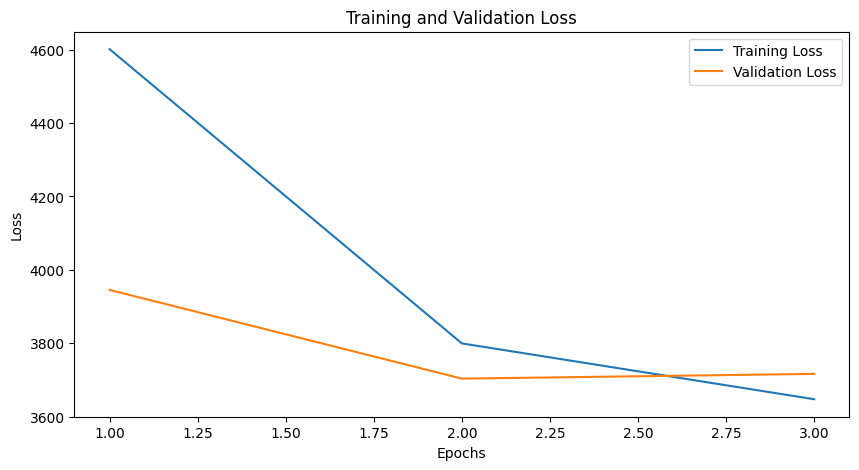

validation: 100%|██████████| 353/353 [00:40<00:00,  8.82it/s]


Epoch 4/40
Training Loss: 3557.5095
Validation Loss: 4414.0260
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:42<00:00,  8.25it/s]


Epoch 5/40
Training Loss: 3536.3589
Validation Loss: 4271.8238
No improvement. Early stopping counter: 3


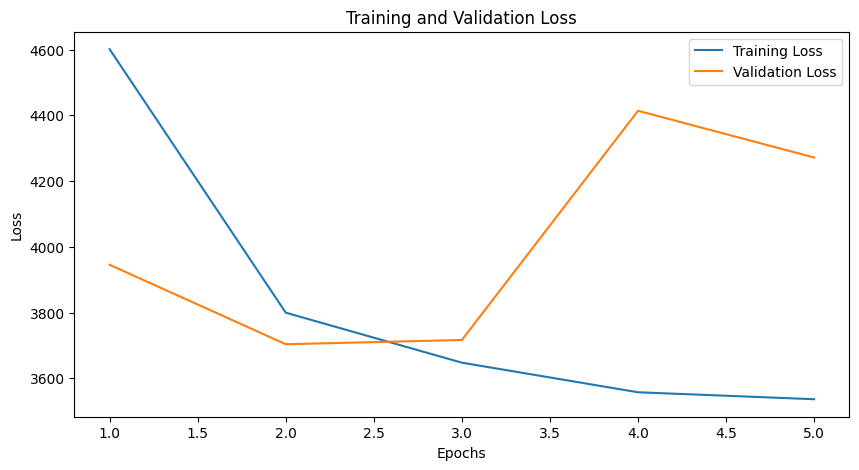

validation: 100%|██████████| 353/353 [00:48<00:00,  7.22it/s]


Epoch 6/40
Training Loss: 3467.1894
Validation Loss: 3499.1388
New best model saved at epoch 6


validation: 100%|██████████| 353/353 [00:40<00:00,  8.81it/s]


Epoch 7/40
Training Loss: 3484.9867
Validation Loss: 3525.0356
No improvement. Early stopping counter: 1


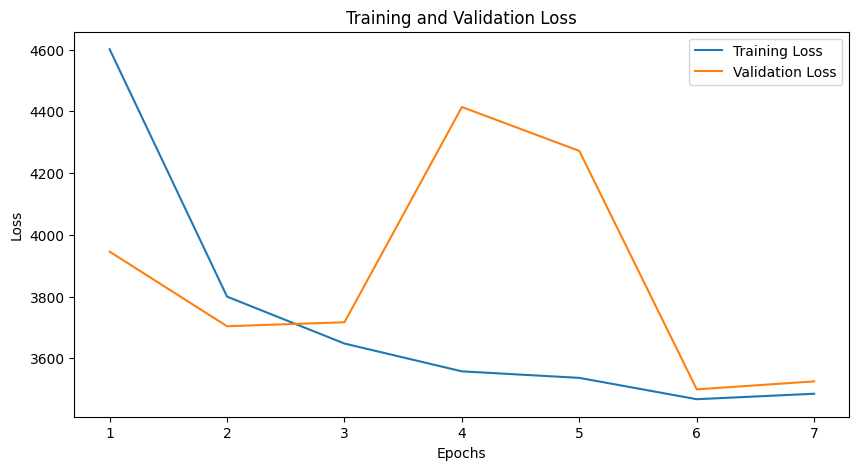

validation: 100%|██████████| 353/353 [00:45<00:00,  7.80it/s]


Epoch 8/40
Training Loss: 3445.1946
Validation Loss: 4648.3689
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:41<00:00,  8.51it/s]


Epoch 9/40
Training Loss: 3449.8329
Validation Loss: 3434.7960
New best model saved at epoch 9


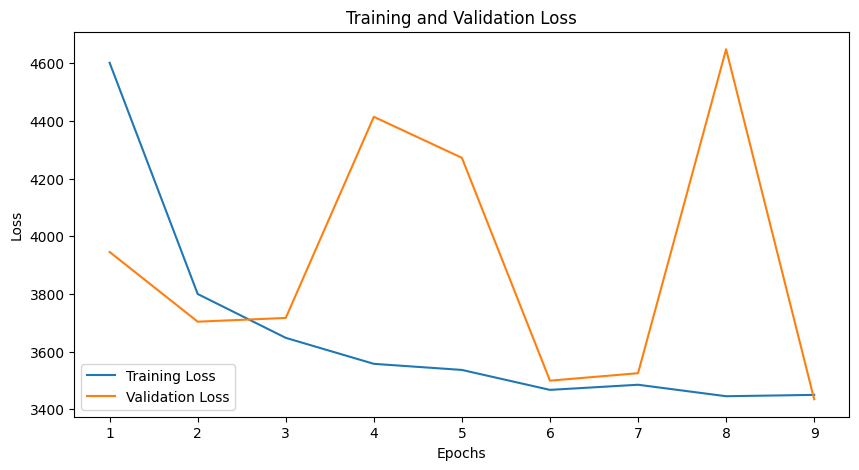

validation: 100%|██████████| 353/353 [00:38<00:00,  9.23it/s]


Epoch 10/40
Training Loss: 3425.7731
Validation Loss: 4355.3579
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [00:45<00:00,  7.68it/s]


Epoch 11/40
Training Loss: 3426.3218
Validation Loss: 4553.0301
No improvement. Early stopping counter: 2


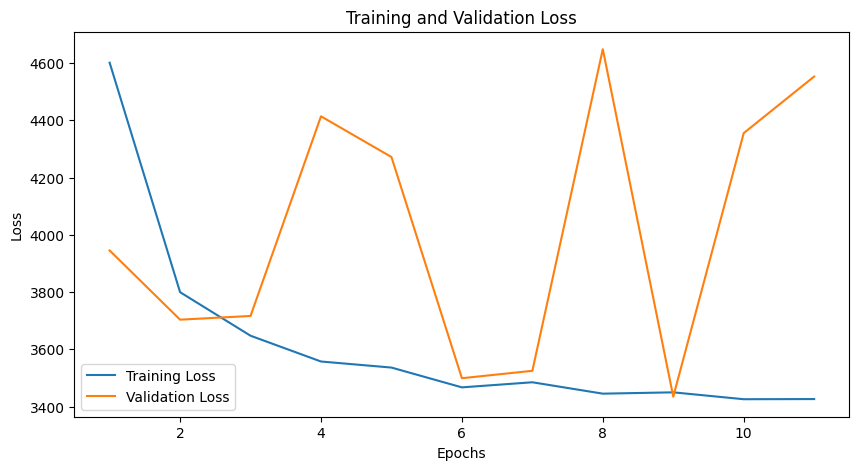

validation: 100%|██████████| 353/353 [00:45<00:00,  7.82it/s]


Epoch 12/40
Training Loss: 3401.2662
Validation Loss: 3488.1985
No improvement. Early stopping counter: 3


validation: 100%|██████████| 353/353 [00:41<00:00,  8.43it/s]


Epoch 13/40
Training Loss: 3387.6396
Validation Loss: 3722.2197
No improvement. Early stopping counter: 4


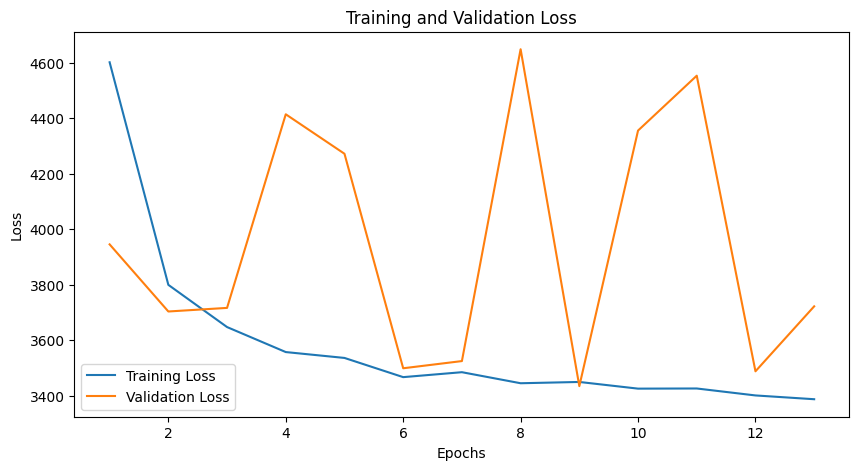

validation: 100%|██████████| 353/353 [00:42<00:00,  8.37it/s]


Epoch 14/40
Training Loss: 3381.7172
Validation Loss: 4884.5435
No improvement. Early stopping counter: 5


validation: 100%|██████████| 353/353 [00:43<00:00,  8.14it/s]


Epoch 15/40
Training Loss: 3395.2797
Validation Loss: 3886.3855
No improvement. Early stopping counter: 6


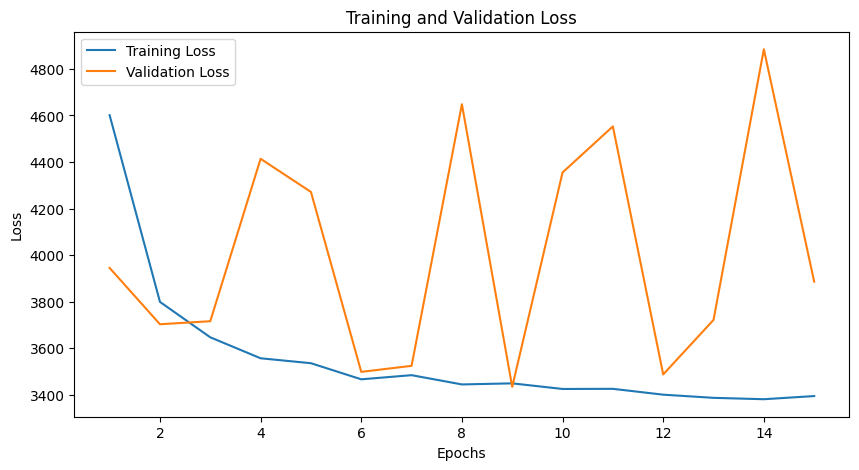

validation: 100%|██████████| 353/353 [00:41<00:00,  8.61it/s]


Epoch 16/40
Training Loss: 3348.8510
Validation Loss: 3290.7128
New best model saved at epoch 16


validation: 100%|██████████| 353/353 [00:44<00:00,  7.94it/s]


Epoch 17/40
Training Loss: 3342.8129
Validation Loss: 3364.7459
No improvement. Early stopping counter: 1


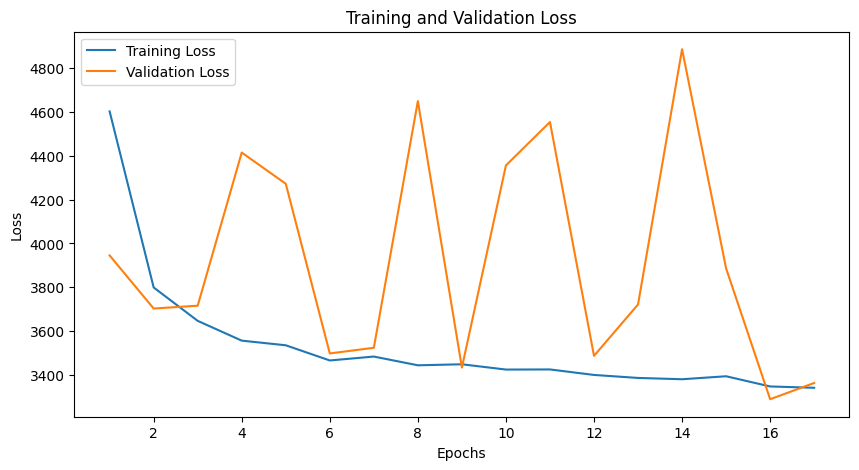

validation: 100%|██████████| 353/353 [00:47<00:00,  7.50it/s]


Epoch 18/40
Training Loss: 3340.9926
Validation Loss: 3288.0372
New best model saved at epoch 18


validation: 100%|██████████| 353/353 [00:43<00:00,  8.11it/s]


Epoch 19/40
Training Loss: 3328.3799
Validation Loss: 4933.8024
No improvement. Early stopping counter: 1


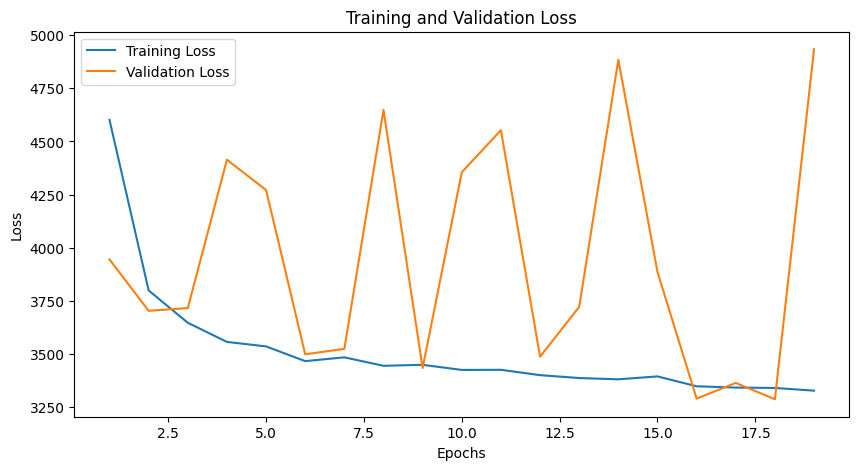

validation: 100%|██████████| 353/353 [00:48<00:00,  7.31it/s]


Epoch 20/40
Training Loss: 3336.9418
Validation Loss: 4063.2429
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:47<00:00,  7.39it/s]


Epoch 21/40
Training Loss: 3320.8075
Validation Loss: 3366.3487
No improvement. Early stopping counter: 3


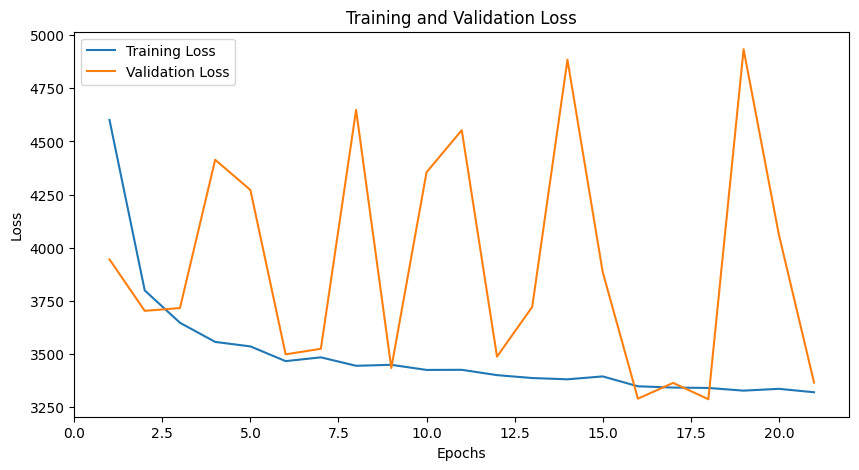

validation: 100%|██████████| 353/353 [00:42<00:00,  8.39it/s]


Epoch 22/40
Training Loss: 3319.1635
Validation Loss: 3281.7640
New best model saved at epoch 22


validation: 100%|██████████| 353/353 [00:46<00:00,  7.55it/s]


Epoch 23/40
Training Loss: 3311.0743
Validation Loss: 4261.0087
No improvement. Early stopping counter: 1


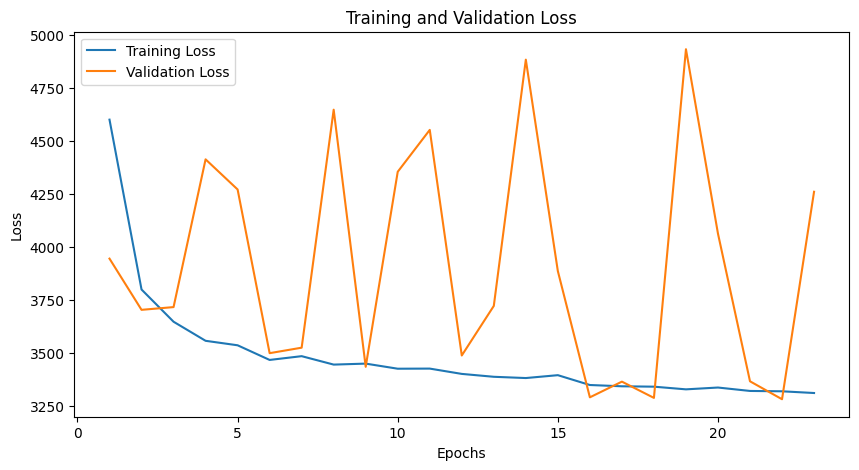

validation: 100%|██████████| 353/353 [00:50<00:00,  7.04it/s]


Epoch 24/40
Training Loss: 3318.5958
Validation Loss: 3415.7582
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:37<00:00,  9.36it/s]


Epoch 25/40
Training Loss: 3311.3752
Validation Loss: 3617.2452
No improvement. Early stopping counter: 3


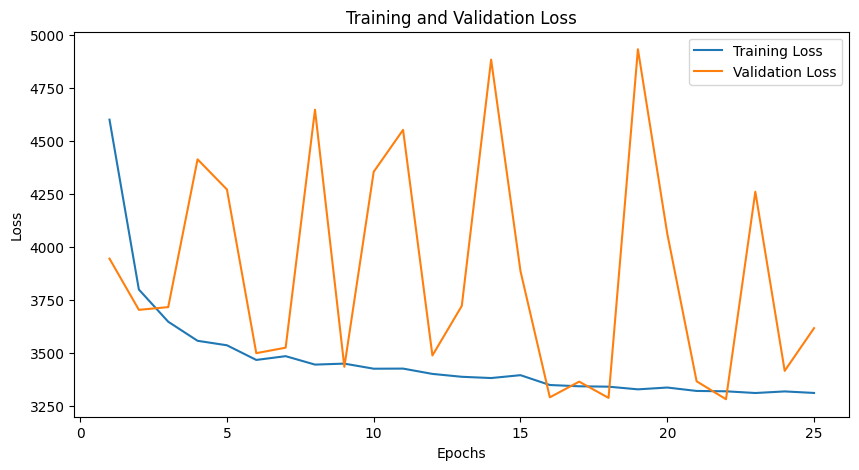

validation: 100%|██████████| 353/353 [00:45<00:00,  7.71it/s]


Epoch 26/40
Training Loss: 3304.8623
Validation Loss: 3371.4775
No improvement. Early stopping counter: 4


validation: 100%|██████████| 353/353 [00:47<00:00,  7.45it/s]


Epoch 27/40
Training Loss: 3309.0671
Validation Loss: 4931.9748
No improvement. Early stopping counter: 5


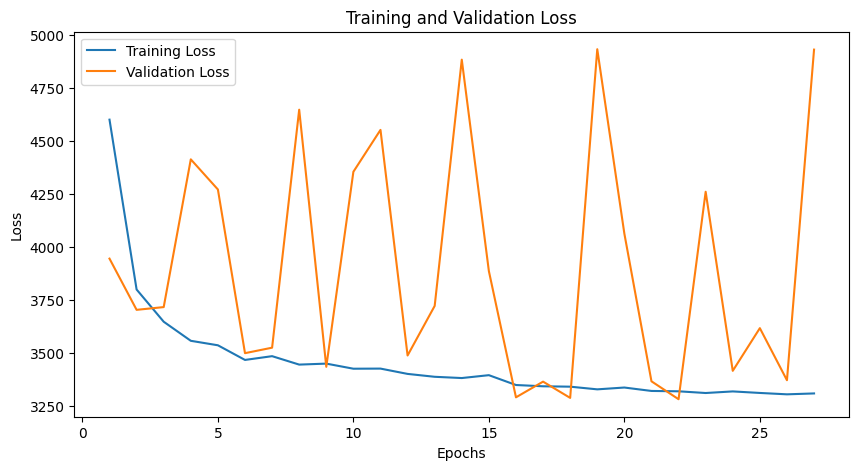

validation: 100%|██████████| 353/353 [00:43<00:00,  8.20it/s]


Epoch 28/40
Training Loss: 3298.5845
Validation Loss: 3465.1243
No improvement. Early stopping counter: 6


validation: 100%|██████████| 353/353 [00:47<00:00,  7.41it/s]


Epoch 29/40
Training Loss: 3279.3848
Validation Loss: 3322.7386
No improvement. Early stopping counter: 7


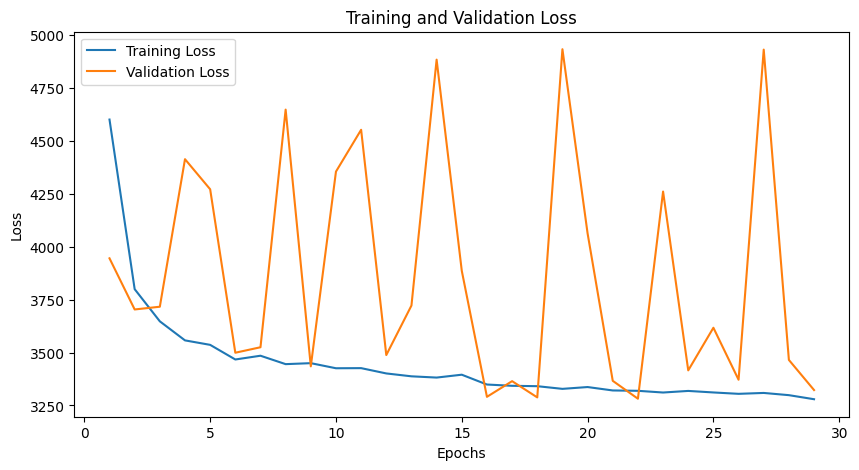

validation: 100%|██████████| 353/353 [00:49<00:00,  7.15it/s]


Epoch 30/40
Training Loss: 3279.9547
Validation Loss: 4933.3692
No improvement. Early stopping counter: 8
Early stopping triggered.
Early stopping triggered.


/tmp/ipykernel_23/2428637641.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


True

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader, device, scheduler)
trainer.train(num_epochs=40)

In [14]:
metrics_df = trainer.test(thres=0.5)
metrics_df

/tmp/ipykernel_23/2428637641.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Testing: 100%|██████████| 7/7 [00:02<00:00,  3.35i

Metric        Value
0       accuracy     0.893694
1   bal_accuracy     0.901379
2      precision     0.961387
3         recall     0.848395
4       f1_score     0.901364
5  jaccard_index     0.820439
6    cohen_kappa     0.787065
7            mcc     0.794313
8           loss  2974.232397

Testing: 100%|██████████| 7/7 [00:01<00:00,  5.71it/s]


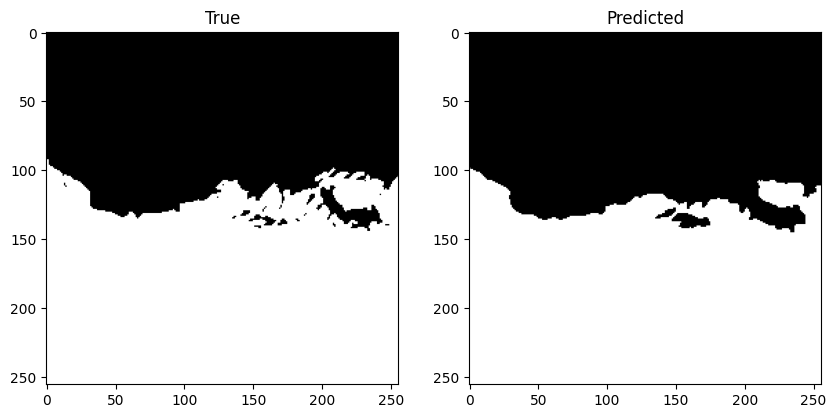

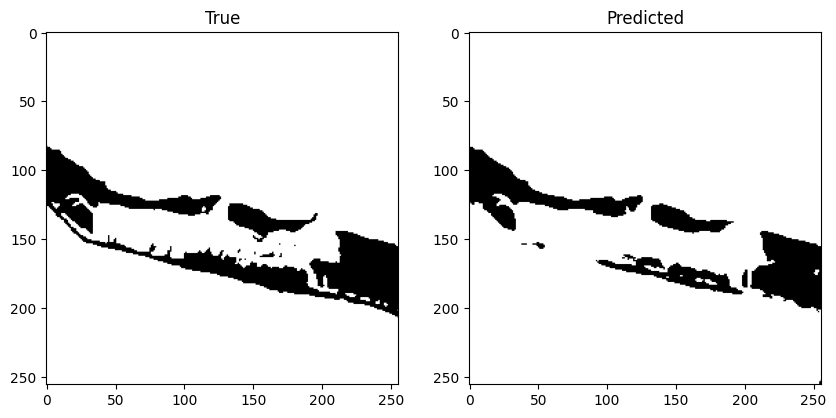

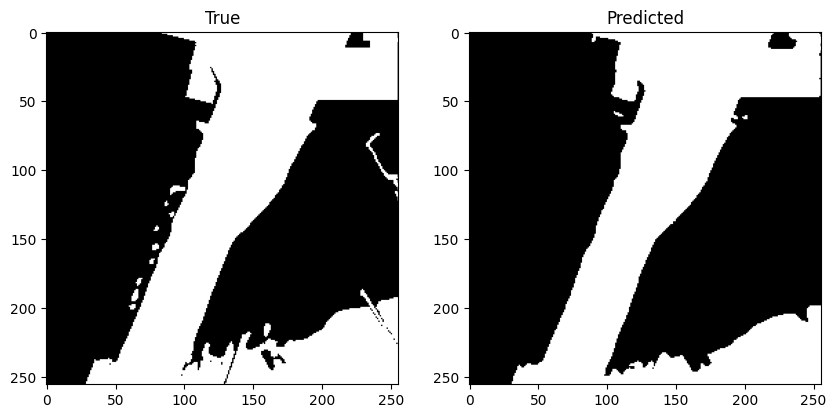

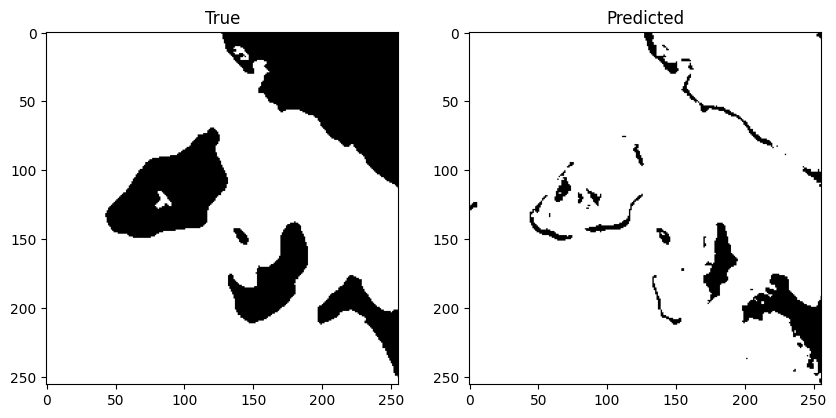

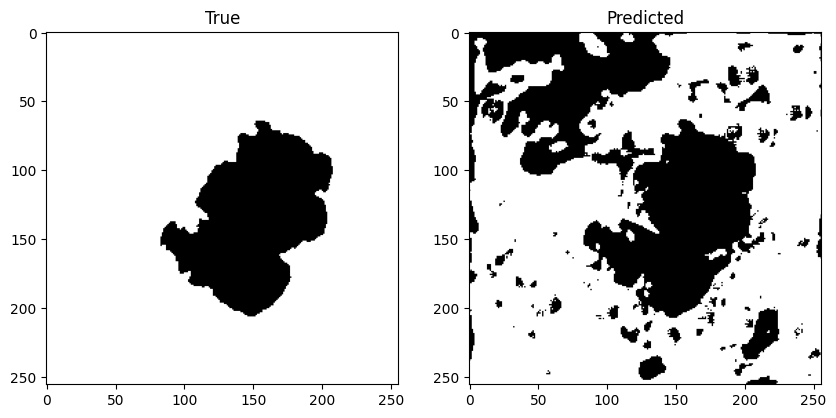

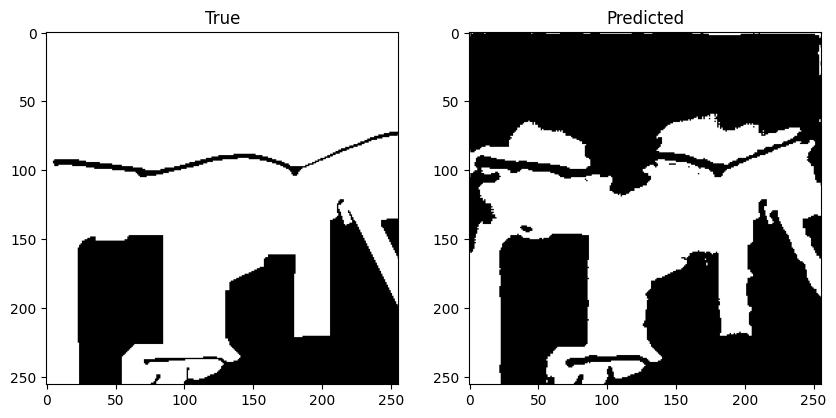

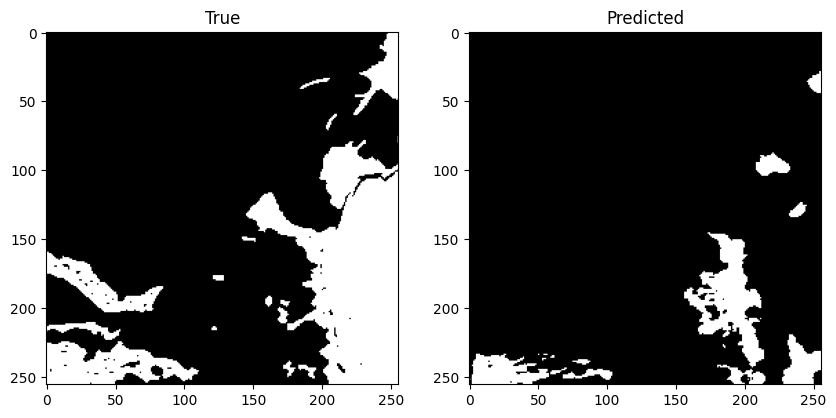

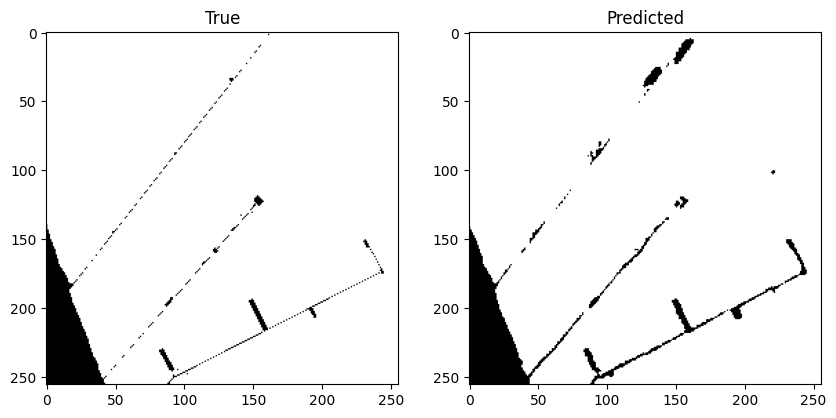

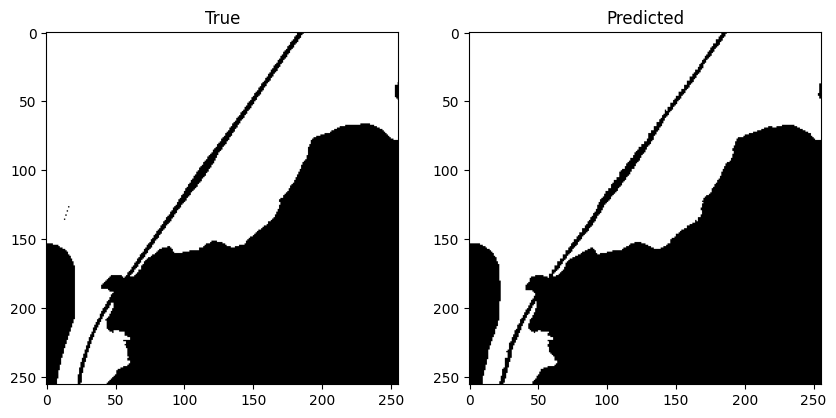

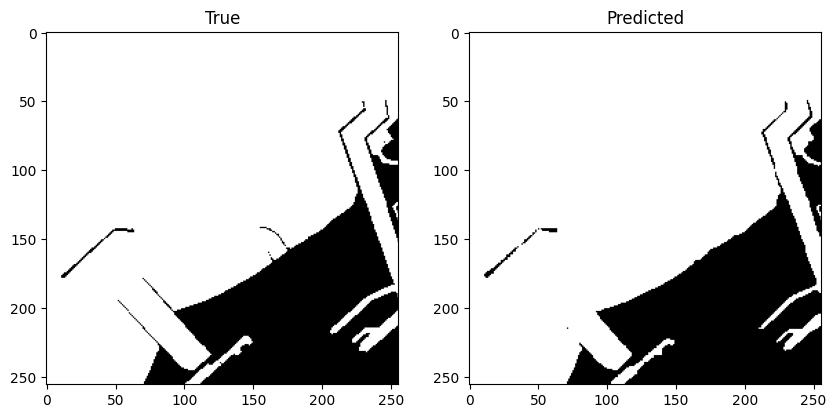

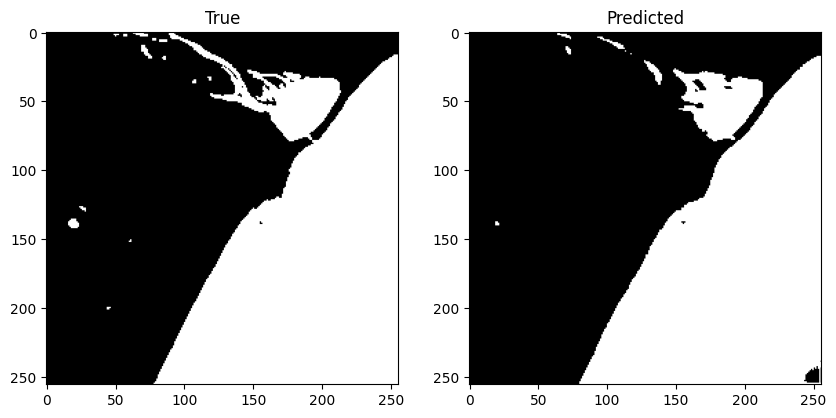

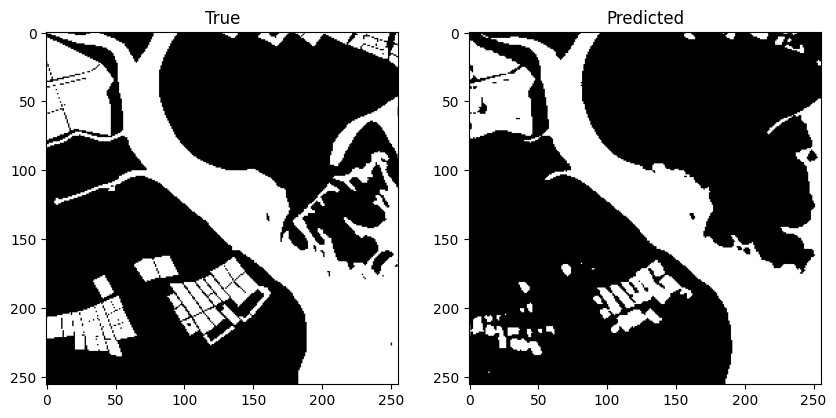

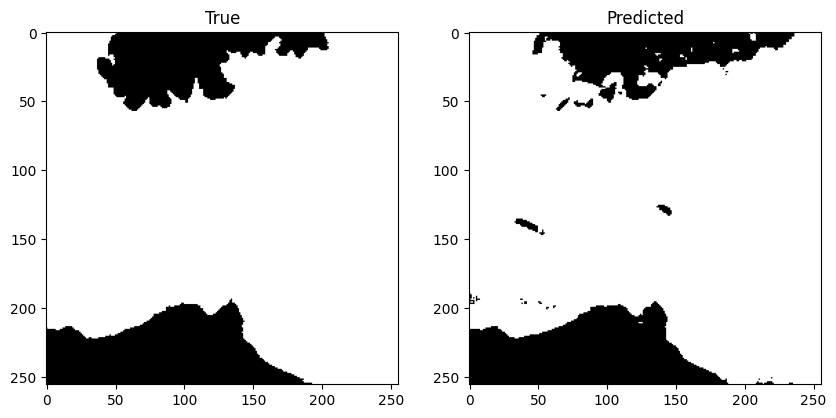

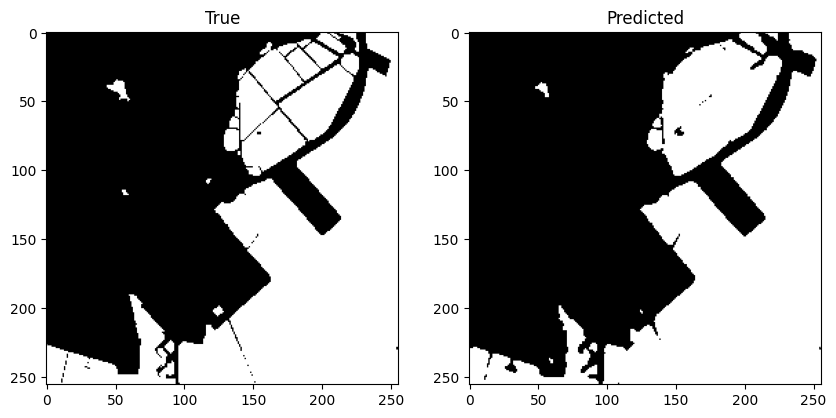

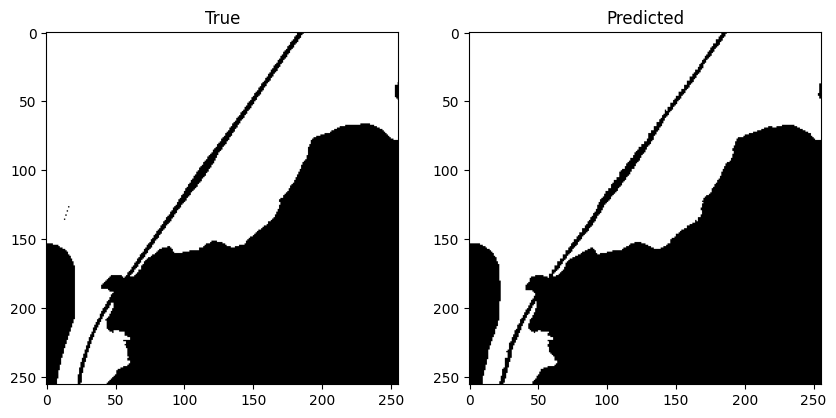

In [15]:
trainer.test_visualize(15)